# Progetto di Ricerca Operativa: Piano di Evacuazione per i Campi Flegrei

**Obiettivo:** Sviluppare un piano di evacuazione per l'area dei Campi Flegrei utilizzando il modello del **Flusso più Rapido (Quickest Flow)**.

**Metodologia:** L'approccio si basa sulla teoria presentata nel paper "Quickest Flows Over Time" di Fleischer e Skutella. Poiché il problema generale è NP-hard, implementeremo l'**algoritmo di 2-approssimazione** descritto nella Sezione 3. Questo approccio riduce il complesso problema dinamico a una serie di problemi di **flusso statico a costo minimo**, risolvibili efficientemente.

## Fase 1: Modellazione Matematica

In questa sezione, formalizziamo il problema utilizzando la notazione matematica standard per i flussi su rete.

### 1.1 Insiemi e Indici

- $V$: Insieme dei **nodi** della rete (incroci, città).
- $A$: Insieme degli **archi** orientati $(i, j)$ che rappresentano i tratti stradali, dove $i, j \in V$.
- $S \subset V$: Sottoinsieme dei nodi che sono **sorgenti** (centri abitati da evacuare).
- $P \subset V$: Sottoinsieme dei nodi che sono **pozzi** (aree sicure, uscite dalla zona rossa).

### 1.2 Parametri del Modello

- $D_v$: **Popolazione** (o domanda) da evacuare dal nodo sorgente $v \in S$. Si assume $D_v > 0$.
- $D_{total}$: Popolazione totale da evacuare, $D_{total} = \sum_{v \in S} D_v$.
- $u_e$: **Capacità** dell'arco $e \in A$ (es. veicoli per ora).
- $\tau_e$: **Tempo di transito** per percorrere l'arco $e \in A$ (es. in ore).

### 1.3 Il Problema del Flusso più Rapido (Quickest Flow)

Il problema originale consiste nel trovare il tempo minimo $T$ per inviare l'intera popolazione $D_{total}$ dalle sorgenti $S$ ai pozzi $P$. Questo richiede la definizione di variabili di flusso dinamiche $f_e(t)$ che dipendono dal tempo, rendendo il problema molto complesso.

### 1.4 L'Approccio di Approssimazione: Riduzione a Flusso Statico a Costo Minimo

Seguendo il paper di Fleischer e Skutella, invece di risolvere il problema dinamico, lo approssimiamo con un modello statico più semplice. L'idea è trovare un piano di flusso che minimizzi il "tempo di viaggio totale" accumulato da tutte le persone evacuate. Questo modello viene risolto all'interno di una ricerca binaria sul tempo totale di evacuazione $T$.

#### Variabili di Decisione (Statiche)

- $x_e$: **Flusso** statico sull'arco $e \in A$ (numero totale di persone/veicoli che usano l'arco durante l'intera evacuazione).

#### Formulazione del Flusso a Costo Minimo

Per ogni tempo candidato $T$ nella nostra ricerca binaria, risolviamo il seguente problema di ottimizzazione:

**Obiettivo:** Minimizzare il tempo di viaggio aggregato.
$$ \min Z = \sum_{e \in A} \tau_e \cdot x_e $$

**Sotto i vincoli:**

1.  **Conservazione del Flusso:** Per ogni nodo $i \in V$, il flusso netto deve eguagliare l'offerta/domanda del nodo.
    $$ \sum_{j : (j,i) \in A} x_{ji} - \sum_{j : (i,j) \in A} x_{ij} = -b_i \quad \forall i \in V $$
    dove:
    - $b_i = D_i$ se $i \in S$ (offerta).
    - $b_i = -\frac{D_{total}}{|P|}$ se $i \in P$ (domanda, distribuita sui pozzi).
    - $b_i = 0$ altrimenti (nodo di transito).

2.  **Capacità degli Archi:** Il flusso su un arco non può superare la sua capacità. *Attenzione: la capacità del modello statico è legata al tempo $T$. La capacità istantanea $u_e$ (veicoli/ora) diventa una capacità totale $u_e \cdot T$ sull'intero orizzonte temporale.*
    $$ 0 \le x_e \le u_e \cdot T \quad \forall e \in A $$

### 1.5 Framework della Ricerca Binaria

1. Inizializza un intervallo di tempo $[T_{min}, T_{max}]$.
2. Fintanto che $T_{max} - T_{min}$ è maggiore di una tolleranza:
   a. Calcola un tempo di prova $T_{guess} = (T_{min} + T_{max}) / 2$.
   b. Risolvi il problema di Flusso a Costo Minimo definito sopra, usando $T_{guess}$ per calcolare le capacità totali degli archi.
   c. Se il problema è **infattibile**, significa che le capacità non sono sufficienti per far passare il flusso in tempo $T_{guess}$. Quindi, $T_{guess}$ è troppo basso. Aggiorna $T_{min} = T_{guess}$.
   d. Se il problema è **fattibile**, abbiamo un piano. Non usiamo il costo per la decisione nella ricerca binaria, ma solo la fattibilità. Significa che un piano esiste per $T_{guess}$. Proviamo a ridurlo. Aggiorna $T_{max} = T_{guess}$.
3. Il risultato è $T_{max}$, una stima del tempo minimo di evacuazione.

## Fase 2: Implementazione in Python con Gurobi

Ora traduciamo il modello matematico in codice Python.

In [10]:
import networkx as nx
import json
import gurobipy as gb
import matplotlib.pyplot as plt
import pandas as pd
import pickle

### 3. Definizione dei Dati di Esempio

Creiamo un piccolo grafo di esempio per testare il nostro modello. **Questa è la sezione che dovrai sostituire con i tuoi dati reali** ottenuti da OpenStreetMap (con OSMnx) e ISTAT.

In [3]:
print("--- Caricamento dei Dati Pre-processati ---")

# Definisci i nomi dei file che hai creato
file_grafo = "grafo_flegreo.graphml"
file_sorgenti_pozzi = "sorgenti_pozzi.json"

# --- 1. Carica il Grafo da File ---
print(f"Caricamento della rete stradale da '{file_grafo}'...")
G_loaded = nx.read_graphml(file_grafo)

# --- 2. Post-Processamento del Grafo (Passaggi Fondamentali!) ---

# a) Conversione dei Nomi dei Nodi in Interi
# read_graphml legge gli ID dei nodi come stringhe, ma noi li usiamo come interi.
# Dobbiamo riconvertirli.
print("Conversione degli ID dei nodi in interi...")
mapping = {node: int(node) for node in G_loaded.nodes()}
G = nx.relabel_nodes(G_loaded, mapping)

# b) Conversione degli Attributi degli Archi in Numeri
# Allo stesso modo, gli attributi numerici vengono letti come stringhe.
# Dobbiamo riconvertirli in float per poterci fare i calcoli.
print("Conversione degli attributi 'capacity' e 'tau' in numeri...")
for u, v, data in G.edges(data=True):
    data['capacity'] = float(data['capacity'])
    data['tau'] = float(data['tau'])

print("Grafo caricato e processato con successo.")
print(f"  - Nodi: {len(G.nodes())}")
print(f"  - Strade: {len(G.edges())}")


# --- 3. Carica Sorgenti e Pozzi da File JSON ---
print(f"Caricamento di sorgenti e pozzi da '{file_sorgenti_pozzi}'...")
with open(file_sorgenti_pozzi, 'r') as f:
    dati_caricati = json.load(f)

# Le chiavi di un dizionario JSON sono sempre stringhe.
# Riconvertiamo le chiavi delle sorgenti (che sono ID di nodi) in interi.
population_sources = {int(k): v for k, v in dati_caricati['sources'].items()}
sink_nodes = dati_caricati['sinks']

print("Sorgenti e pozzi caricati con successo.")
print(f"  - Numero di nodi sorgente: {len(population_sources)}")
print(f"  - Numero di nodi pozzo: {len(sink_nodes)}")
print(f"  - Popolazione totale da evacuare: {sum(population_sources.values()):.0f}")


--- Caricamento dei Dati Pre-processati ---
Caricamento della rete stradale da 'grafo_flegreo.graphml'...
Conversione degli ID dei nodi in interi...
Conversione degli attributi 'capacity' e 'tau' in numeri...
Grafo caricato e processato con successo.
  - Nodi: 51138
  - Strade: 112367
Caricamento di sorgenti e pozzi da 'sorgenti_pozzi.json'...
Sorgenti e pozzi caricati con successo.
  - Numero di nodi sorgente: 16
  - Numero di nodi pozzo: 6
  - Popolazione totale da evacuare: 781000


### 4. Funzione per Risolvere il Flusso Statico (Gurobi)

Questa funzione implementa il modello di flusso a costo minimo descritto matematicamente sopra. Prende in input il tempo candidato $T$ per calcolare le capacità totali.

In [4]:
def solve_static_flow(graph, supplies, T):
    """
    Risolve il problema del flusso a costo minimo per un dato orizzonte temporale T.
    """
    model = gb.Model("StaticFlowForEvacuation")

    # Variabili: flusso su ogni arco
    x = model.addVars(graph.edges(), name="flow", lb=0)

    # Obiettivo: minimizzare il costo (tempo di viaggio totale)
    model.setObjective(
        gb.quicksum(graph.edges[u, v]['tau'] * x[u, v] for u, v in graph.edges()),
        gb.GRB.MINIMIZE
    )

    # Vincoli di capacità totale per l'orizzonte T
    model.addConstrs(
        (x[u, v] <= graph.edges[u, v]['capacity'] * T for u, v in graph.edges()),
        name="capacity"
    )

    # Vincoli di conservazione del flusso
    for node in graph.nodes():
        flow_out = gb.quicksum(x[node, v] for u, v in graph.out_edges(node))
        flow_in = gb.quicksum(x[u, node] for u, v in graph.in_edges(node))
        supply = supplies.get(node, 0)
        model.addConstr((flow_out - flow_in == supply), name=f"flow_conservation_{node}")

    model.setParam('OutputFlag', 0)
    model.optimize()

    if model.Status == gb.GRB.OPTIMAL:
        flow_plan = {uv: x[uv].X for uv in x}
        return True, flow_plan # Restituisce la fattibilità e il piano
    else:
        return False, None # Il problema è infattibile per questo T

### 5. Algoritmo di Ricerca Binaria

Questa funzione principale orchestra il processo, chiamando il solutore Gurobi all'interno del loop di ricerca.

In [5]:
def find_quickest_evacuation_time(graph, population_sources, sink_nodes):
    total_population = sum(population_sources.values())

    supplies = {node: pop for node, pop in population_sources.items()}
    if sink_nodes:
        demand_per_sink = -total_population / len(sink_nodes)
        for node in sink_nodes:
            supplies[node] = demand_per_sink

    print(f"Inizio ricerca del tempo di evacuazione per {total_population} persone.")

    # Stime iniziali per T
    T_min = 0
    T_max = 24 # Limite superiore iniziale (es. 24 ore)

    # Prima verifichiamo se T_max è fattibile, altrimenti lo aumentiamo
    is_feasible, _ = solve_static_flow(graph, supplies, T_max)
    while not is_feasible:
        print(f"Il limite superiore T_max={T_max} ore non è sufficiente. Raddoppio.")
        T_max *= 2
        is_feasible, _ = solve_static_flow(graph, supplies, T_max)

    print(f"Trovato un limite superiore fattibile: {T_max} ore. Inizio ricerca binaria.")

    tolerance = 0.01 # Tolleranza in ore (circa 36 secondi)
    optimal_time = T_max
    final_flow_plan = None

    for i in range(100): # Limita le iterazioni per sicurezza
        if T_max - T_min <= tolerance:
            break

        T_guess = (T_min + T_max) / 2
        print(f"Iterazione {i+1}: Intervallo [{T_min:.2f}, {T_max:.2f}], Tento T = {T_guess:.2f}")

        is_feasible, flow_plan = solve_static_flow(graph, supplies, T_guess)

        if is_feasible:
            # Se fattibile, T_guess diventa il nuovo massimo e salviamo la soluzione
            T_max = T_guess
            optimal_time = T_guess
            final_flow_plan = flow_plan
        else:
            # Se non fattibile, T_guess è troppo basso
            T_min = T_guess

    return optimal_time, final_flow_plan

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def visualizza_piano_statico_pulito(grafo, piano_flusso, best_time, sources, sinks, soglia_saturazione=50, soglia_pop_label=50000):
    """
    Crea una mappa statica del piano di evacuazione, evidenziando le strade in base alla saturazione
    e etichettando solo le sorgenti con popolazione superiore a una soglia.

    Args:
        grafo (nx.DiGraph): Il grafo della rete stradale.
        piano_flusso (dict): Il dizionario con i flussi risultanti.
        best_time (float): Il tempo T* calcolato.
        sources (dict): Dizionario {nodo_sorgente: popolazione}.
        sinks (list): Lista dei nodi pozzo.
        soglia_saturazione (int): Mostra solo le strade con saturazione >= a questa soglia (in %).
        soglia_pop_label (int): Mostra etichette solo per sorgenti con popolazione >= a questa soglia.
    """
    print(f"\n--- Creazione Mappa Statica Pulita (Saturazione >= {soglia_saturazione}%) ---")

    # 1. Prepara i dati per il plotting
    try:
        pos = {node: (data['x'], data['y']) for node, data in grafo.nodes(data=True)}
    except KeyError:
        print("ERRORE: I nodi del grafo non contengono le coordinate 'x' e 'y'. Impossibile plottare.")
        return

    archi_saturi = []
    for u, v, data in grafo.edges(data=True):
        flow = piano_flusso.get((u, v), 0)
        if flow > 1:
            total_capacity = data.get('capacity', 0) * best_time
            saturation_percent = (flow / total_capacity * 100) if total_capacity > 0 else 0

            if saturation_percent >= soglia_saturazione:
                archi_saturi.append({
                    'edge': (u, v),
                    'saturation': saturation_percent
                })

    if not archi_saturi:
        print(f"Nessuna strada trovata con saturazione superiore al {soglia_saturazione}%. Prova ad abbassare la soglia.")
        return

    edgelist = [item['edge'] for item in archi_saturi]
    saturations = [item['saturation'] for item in archi_saturi]
    widths = [0.5 + (s / 100 * 6) for s in saturations] # Spessore da 0.5 a 6.5

    # 2. Creazione del Grafico
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_facecolor('white')

    # Disegna l'intera rete come sfondo grigio molto leggero
    nx.draw_networkx_edges(grafo, pos, ax=ax, edge_color='#e0e0e0', width=0.3, arrows=False)

    # Disegna sopra solo gli archi saturi
    edges_plot = nx.draw_networkx_edges(
        grafo, pos, ax=ax, edgelist=edgelist, edge_color=saturations,
        edge_cmap=plt.cm.Spectral, width=widths, arrows=False
    )

    # 3. Disegna ed etichetta Sorgenti e Pozzi
    # Disegna tutti i nodi sorgente
    nx.draw_networkx_nodes(grafo, pos, nodelist=list(sources.keys()), node_color='lime', node_size=50, label='Sorgenti')
    # Disegna i pozzi
    nx.draw_networkx_nodes(grafo, pos, nodelist=sinks, node_color='cyan', node_size=50, label='Pozzi')

    # Crea le etichette SOLO per le sorgenti con popolazione sopra la soglia
    labels_da_mostrare = {}
    for node_id, pop in sources.items():
        if pop >= soglia_pop_label:
            labels_da_mostrare[node_id] = f"{pop/1000:.0f}k" # Formato "80k"

    nx.draw_networkx_labels(grafo, pos, labels=labels_da_mostrare, font_size=9, font_color='black',
                             bbox=dict(facecolor='lime', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2'))

    # 4. Finalizzazione del Grafico
    ax.set_title(f"Piano di Evacuazione - Saturazione Strade (Soglia > {soglia_saturazione}%)", fontsize=22)

    norm = mcolors.Normalize(vmin=soglia_saturazione, vmax=100)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Spectral, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.7, orientation='vertical')
    cbar.set_label('Saturazione della Strada (%)', fontsize=16)

    ax.legend(prop={'size': 15})
    plt.show()

### 6. Esecuzione e Analisi dei Risultati

In [7]:
best_time, evacuation_plan = find_quickest_evacuation_time(G, population_sources, sink_nodes)

if best_time is not None:
    print("\n--- PIANO DI EVACUAZIONE TROVATO ---")
    print(f"Tempo di evacuazione stimato: {best_time:.2f} ore")
    print("Nota: Questo è il risultato della 2-approssimazione. Il tempo ottimale reale non è superiore a questo valore, e non è inferiore a best_time/2.")

    print("\nFlusso totale per ogni strada (persone/veicoli sull'intero periodo):")
    total_flow_out = 0
    for (u, v), flow_val in evacuation_plan.items():
        if flow_val > 1e-6: # Mostra solo gli archi usati
            capacity_total = G.edges[u,v]['capacity'] * best_time
            saturation = (flow_val / capacity_total) * 100
            print(f"  - Da {u} a {v}: {flow_val:.0f} persone [Saturazione: {saturation:.1f}%]")
            if u in population_sources:
                total_flow_out += flow_val

    print(f"\nFlusso totale in uscita dalle sorgenti: {total_flow_out:.0f}")
    print(f"Popolazione totale da evacuare: {sum(population_sources.values())}")
else:
    print("Non è stato possibile trovare un piano di evacuazione.")

Inizio ricerca del tempo di evacuazione per 781000 persone.
Set parameter Username
Set parameter LicenseID to value 2633434
Academic license - for non-commercial use only - expires 2026-03-07
Il limite superiore T_max=24 ore non è sufficiente. Raddoppio.
Il limite superiore T_max=48 ore non è sufficiente. Raddoppio.
Trovato un limite superiore fattibile: 96 ore. Inizio ricerca binaria.
Iterazione 1: Intervallo [0.00, 96.00], Tento T = 48.00
Iterazione 2: Intervallo [48.00, 96.00], Tento T = 72.00
Iterazione 3: Intervallo [72.00, 96.00], Tento T = 84.00
Iterazione 4: Intervallo [72.00, 84.00], Tento T = 78.00
Iterazione 5: Intervallo [72.00, 78.00], Tento T = 75.00
Iterazione 6: Intervallo [72.00, 75.00], Tento T = 73.50
Iterazione 7: Intervallo [72.00, 73.50], Tento T = 72.75
Iterazione 8: Intervallo [72.00, 72.75], Tento T = 72.38
Iterazione 9: Intervallo [72.00, 72.38], Tento T = 72.19
Iterazione 10: Intervallo [72.19, 72.38], Tento T = 72.28
Iterazione 11: Intervallo [72.28, 72.38],


--- Creazione Mappa Statica Pulita (Saturazione >= 0%) ---


C:\Users\vince\AppData\Local\Temp\ipykernel_26756\2178758913.py:56: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  edges_plot = nx.draw_networkx_edges(


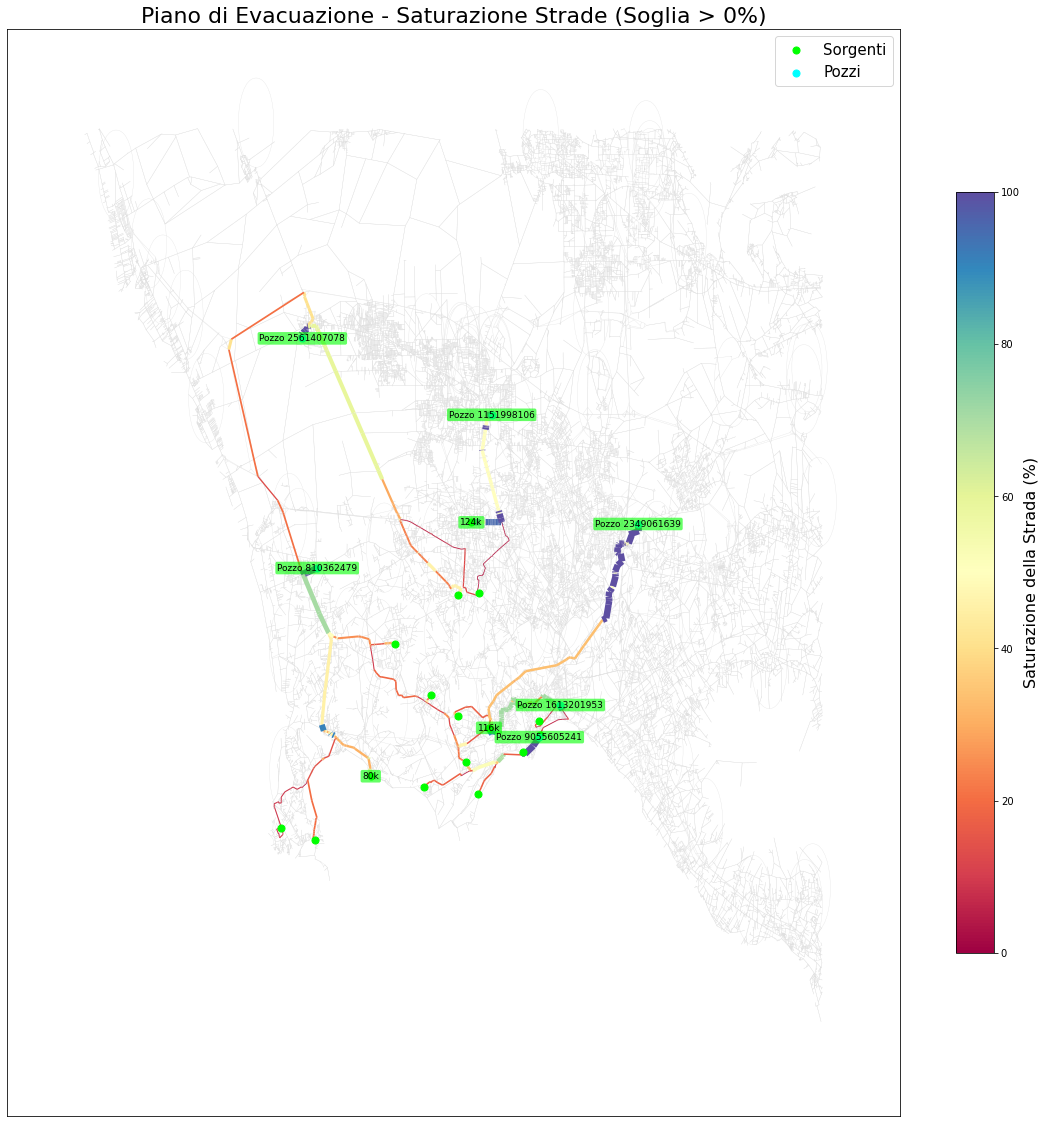


--- Creazione Mappa Statica Pulita (Saturazione >= 40%) ---


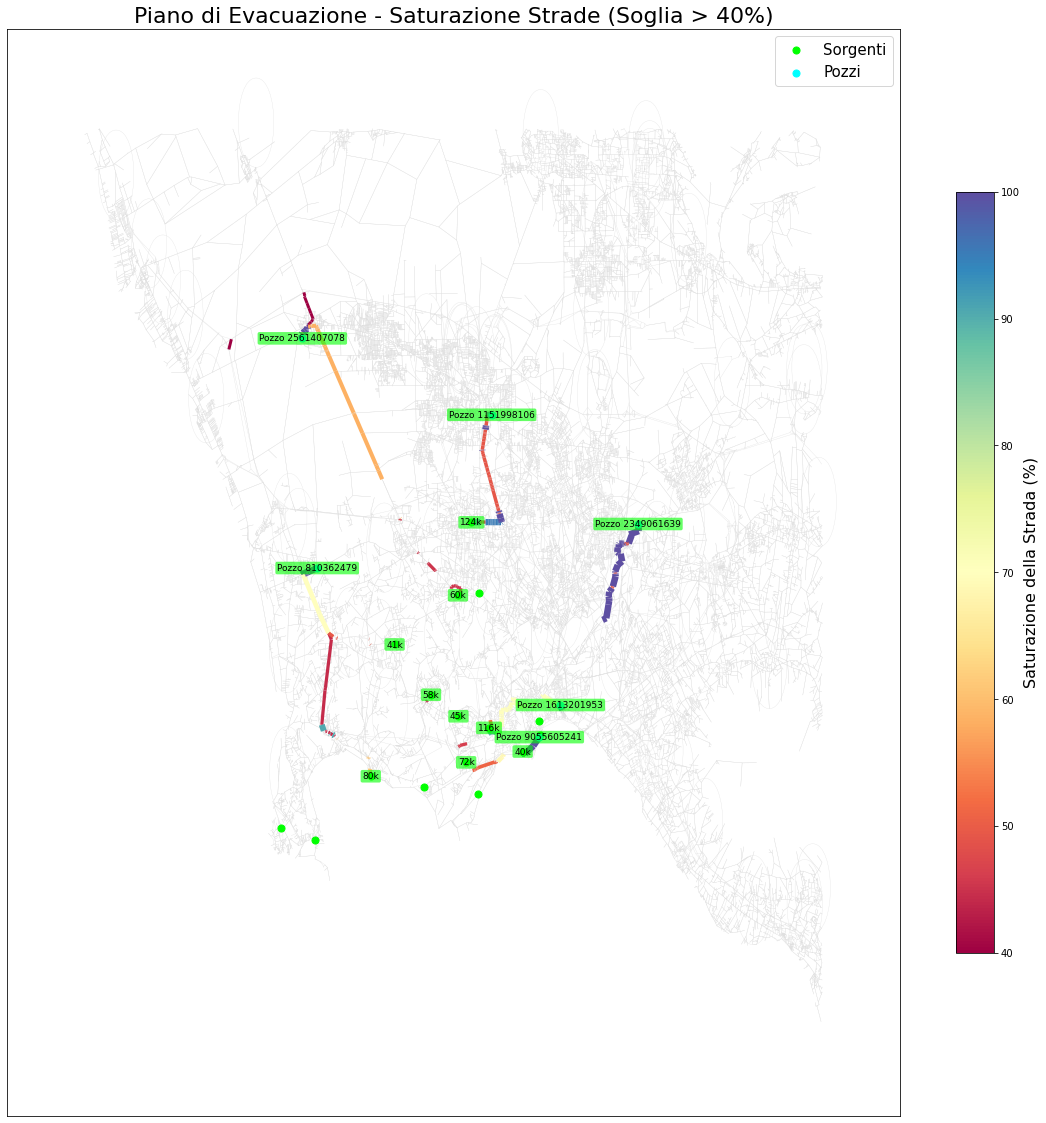

In [19]:
if best_time is not None and evacuation_plan is not None:
    # Mostra tutte le strade utilizzate (soglia = 0)
    visualizza_piano_statico_pulito(
        G,
        evacuation_plan,
        best_time,
        population_sources,
        sink_nodes,
        soglia_saturazione=0,
        soglia_pop_label=75000
    )

    # Esempio 2: Mostra tutte le strade moderatamente trafficate (saturazione > 40%)
    # e le etichette per le sorgenti con più di 40.000 persone.
    visualizza_piano_statico_pulito(
        G,
        evacuation_plan,
        best_time,
        population_sources,
        sink_nodes,
        soglia_saturazione=40,
        soglia_pop_label=40000
    )
else:
    print("Nessun piano di evacuazione da visualizzare.")

In [11]:
if best_time is not None:
    print("\n--- Salvataggio dei risultati in un unico file ---")

    # 1. Raccogli tutti gli oggetti che vuoi salvare in un unico dizionario
    risultati_da_salvare = {
        'grafo': G,
        'sorgenti': population_sources,
        'pozzi': sink_nodes,
        'tempo_ottimo': best_time,
        'piano_flusso': evacuation_plan
    }

    # 2. Usa pickle per scrivere il dizionario in un file binario
    nome_file_risultati = "risultati_evacuazione.pkl"
    with open(nome_file_risultati, 'wb') as f:
        pickle.dump(risultati_da_salvare, f)

    print(f"Tutti i risultati sono stati salvati con successo nel file: '{nome_file_risultati}'")
else:
    print("Nessuna soluzione trovata, nessun file di risultati è stato creato.")



--- Salvataggio dei risultati in un unico file ---
Tutti i risultati sono stati salvati con successo nel file: 'risultati_evacuazione.pkl'


In [8]:
import folium
from folium.plugins import BeautifyIcon

def visualizza_mappa_interattiva(grafo_visualizzazione, piano_flusso, best_time, sources, sinks):
    """
    Crea una mappa HTML interattiva con Folium per visualizzare il piano di evacuazione.
    """
    print("\n--- Creazione della Mappa Interattiva con Folium ---")

    # 1. Trova il centro della mappa per la visualizzazione iniziale
    centro_mappa_lat = gdf['geometry'].unary_union.centroid.y
    centro_mappa_lon = gdf['geometry'].unary_union.centroid.x

    # 2. Crea la mappa di base
    m = folium.Map(location=[centro_mappa_lat, centro_mappa_lon], zoom_start=12, tiles="CartoDB dark_matter")

    # 3. Prepara una scala di colori per la saturazione
    # Mappa un valore di saturazione (0-100) a un colore (dal blu al rosso)
    colormap = cm.get_cmap('hot_r', 100)

    # 4. Aggiungi le strade del piano di evacuazione alla mappa
    for u, v, data in grafo_visualizzazione.edges(data=True):
        flow = piano_flusso.get((u, v), 0)
        if flow > 1:
            # Calcola la saturazione per questa strada
            total_capacity = data['capacity'] * best_time
            saturation = (flow / total_capacity * 100) if total_capacity > 0 else 0

            # Solo le strade con saturazione > 1% per pulizia
            if saturation > 1:
                # Ottieni le coordinate della strada
                coords = [(n['y'], n['x']) for n in data['geometry'].coords]

                # Scegli il colore in base alla saturazione
                colore_strada = mcolors.to_hex(colormap(int(saturation)))

                # Crea la linea sulla mappa
                linea = folium.PolyLine(
                    locations=coords,
                    color=colore_strada,
                    weight=2 + (saturation / 100 * 8), # Spessore da 2 a 10
                    opacity=0.8
                )

                # Aggiungi un popup che appare al click
                popup_html = f"""
                <b>Strada da {u} a {v}</b><br>
                Flusso: {flow:,.0f} veicoli<br>
                Saturazione: {saturation:.1f}%
                """
                linea.add_child(folium.Popup(popup_html))
                linea.add_to(m)

    # 5. Aggiungi i nodi Sorgente e Pozzo
    for node_id, pop in sources.items():
        node_data = grafo_visualizzazione.nodes[node_id]
        folium.CircleMarker(
            location=(node_data['y'], node_data['x']),
            radius=8,
            color='lime',
            fill=True,
            fill_color='lime',
            fill_opacity=0.7,
            popup=f"<b>Sorgente (Nodo {node_id})</b><br>Popolazione: {pop:,.0f}"
        ).add_to(m)

    for node_id in sinks:
        node_data = grafo_visualizzazione.nodes[node_id]
        folium.CircleMarker(
            location=(node_data['y'], node_data['x']),
            radius=8,
            color='cyan',
            fill=True,
            fill_color='cyan',
            fill_opacity=0.7,
            popup=f"<b>Pozzo (Nodo {node_id})</b>"
        ).add_to(m)

    # 6. Salva la mappa in un file HTML
    nome_file_mappa = "mappa_evacuazione.html"
    m.save(nome_file_mappa)
    print(f"Mappa interattiva salvata in '{nome_file_mappa}'. Aprila con un browser.")


# --- ESECUZIONE ---
# Per usare questa funzione, devi modificare leggermente lo script `crea_grafo.py`
# per salvare anche il grafo non semplificato 'G_real_mdg' (es. con pickle)
# e poi caricarlo nel notebook. Per semplicità, la eseguiamo nello stesso script
# di preparazione dati, dopo aver calcolato il piano.
# OPPURE, per un test rapido, la puoi chiamare passando G_simple, ma le strade saranno linee rette.

# Esempio di chiamata (nel notebook di analisi, dopo l'ottimizzazione):
# visualizza_mappa_interattiva(G_simple, evacuation_plan_real, best_time_real, sources_real, sinks_real_nodes)

In [9]:
if best_time is not None and evacuation_plan is not None:
    # Mostra tutte le strade utilizzate (soglia = 0)
    visualizza_mappa_interattiva(
        G,
        evacuation_plan,
        best_time,
        population_sources,
        sink_nodes)

    visualizza_piano_statico_pulito(
        G,
        evacuation_plan,
        best_time,
        population_sources,
        sink_nodes,
        soglia_saturazione=85,
        soglia_pop_label=75000
    )

    # Esempio 2: Mostra tutte le strade moderatamente trafficate (saturazione > 40%)
    # e le etichette per le sorgenti con più di 40.000 persone.
    visualizza_piano_statico_pulito(
        G,
        evacuation_plan,
        best_time,
        population_sources,
        sink_nodes,
        soglia_saturazione=40,
        soglia_pop_label=40000
    )
else:
    print("Nessun piano di evacuazione da visualizzare.")


--- Creazione della Mappa Interattiva con Folium ---


NameError: name 'gdf' is not defined

### 7. Conclusioni e Sviluppi Futuri

Questo notebook ha implementato un algoritmo di 2-approssimazione per il problema del flusso più rapido, fornendo un piano di evacuazione e una stima del tempo necessario.

**Come interpretare i risultati:**
- Il **tempo di evacuazione** è la stima del tempo minimo necessario per completare l'operazione.
- Il **piano di flusso** indica quante persone/veicoli dovrebbero percorrere ogni strada durante l'intera evacuazione.
- La **saturazione** è l'indicatore più importante: strade con saturazione vicina al 100% sono i **colli di bottiglia** del sistema. Qualsiasi intervento per migliorare i tempi di evacuazione dovrebbe concentrarsi su queste strade.

**Sviluppi futuri:**
1. **Integrazione Dati Reali:** Sostituire il grafo di esempio con i dati reali della rete stradale dei Campi Flegrei (da OSMnx) e della popolazione (da ISTAT).
2. **Visualizzazione Geografica:** Usare `Folium` o `GeoPandas` per visualizzare il piano di evacuazione su una mappa, colorando le strade in base al flusso o alla saturazione.
3. **Modello più Avanzato:** Considerare estensioni come l'evacuazione per fasi (non tutti partono contemporaneamente) o l'inclusione di diverse modalità di trasporto.
4. **Implementazione FPTAS:** Per una maggiore precisione, si potrebbe implementare l'approccio FPTAS dalla Sezione 4 del paper di Fleischer e Skutella, costruendo la rete condensata espansa nel tempo.